<p align = "justify"; style = "font-size:20px;"> The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions. The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by: </p>

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

<p align = "justify"; style = "font-size:20px;"> where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition. This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation. A typical example of double well potential is given by the following function </p>

$$
f(\eta) = \eta^2(\eta-1)^2
$$

<p align = "justify"; style = "font-size:20px;"> which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero. The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa). Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$. Discretization of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm. We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as </p>

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

<p align = "justify"; style = "font-size:20px;"> Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is: </p>

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

<p align = "justify"; style = "font-size:20px;"> Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix. In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing </p>

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$

<p align = "justify"; style = "font-size:20px;"> where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$. This results in a linear system </p>

$$
A x = b
$$

<p align = "justify"; style = "font-size:20px;"> where </p>

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big)
$$

<p align = "justify"; style = "font-size:20px;"> and </p>

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

<p align = "justify"; style = "font-size:20px;"> where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$. </p>


# Setup Environment

In [137]:
%reset -f
%pylab inline
import scipy
from scipy.interpolate import *

Populating the interactive namespace from numpy and matplotlib


In [138]:
def f(eta):
    return eta ** 2 * (eta - 1) ** 2;

In [139]:
degree = 2; ndof = 16;
support_points = linspace(0, 1, 16);

# Step 1
<p align = "justify"; style = "font-size:20px;"> Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9. In particular: </p>

## Step 1.1

<p align = "justify"; style = "font-size:20px;"> Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`. The derivative of double well potential function, $f(\eta) = \eta^2(\eta-1)^2$, is:</p>

$$f'(\eta) = 2 \eta (\eta-1)^2 + \eta^2 2 (\eta-1) = 4 \eta^3 -6 \eta^2 +2 \eta$$

In [140]:
def F(eta):
    '''Derivative of f(eta)'''
    return 4 * eta ** 3 - 6 * eta ** 2 + 2 * eta;

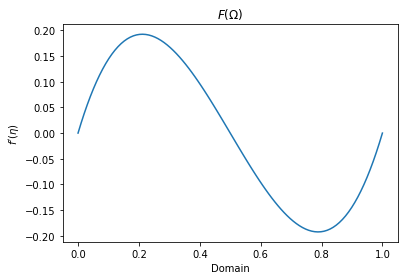

In [141]:
N = 100; x = linspace(0, 1, N);
plt.title("$F(\Omega)$")
plt.xlabel("Domain")
plt.ylabel("$f'(\eta)$")
plot(x, F(x))

## Step 1.2

<p align = "justify"; style = "font-size:20px;"> Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`. </p>

In [142]:
def compute_basis_functions(support_points, degree):
    ''' Compute the piecewise polynomial objects. '''

    basis = []; dbasis = [];
    for i in range(len(support_points)):
        c  = support_points*0; c[i] = 1;
        bi = PPoly.from_spline(splrep(support_points, c, k = degree));

        basis.append(bi); dbasis.append(bi.derivative(1));
    return basis, dbasis # Returning "dbasis" is convenient for solve_allen_cahan when computing matrices M and K;

def plot_basis_functions(basis, x, support_points):
    ''' Check correctness of basis function computation. '''

    B = np.zeros((x.shape[0], len(basis)));
    for i, basis_vector in enumerate(basis):
        B[:, i] = basis_vector(x);

    fig, axs = plt.subplots(2, figsize = (10, 10));
    _ = axs[0].plot(x, B);
    _ = axs[1].plot(x, f(x));
    _ = axs[1].plot(support_points, f(support_points), 'ro');
    _ = axs[1].plot(x, B.dot(f(support_points)));

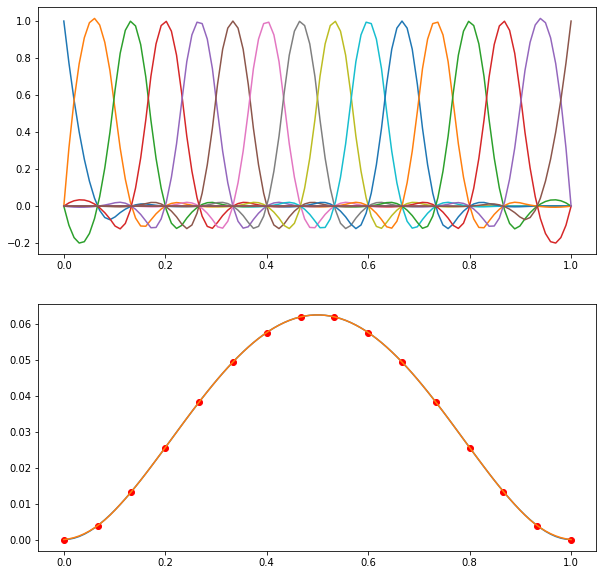

In [143]:
basis, _ = compute_basis_functions(support_points, degree)
plot_basis_functions(basis, x, support_points);

## Step 1.3

<p align = "justify"; style = "font-size:20px;"> Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`. </p>

In [144]:
def compute_global_quadrature(basis, n_gauss_quadrature_points):
    ''' Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis (i.e., unique(basis.x)),
        and create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to integrate on each interval. '''

    intervals = unique(basis[0].x); # Make sure every interval border is taken only once...
    # and make sure we can integrate exactly the product of two basis functions...
    q, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points + 1);
    # Rescale the points and weights to work from zero to one (i.e., base interpolating polynomial ([-1,1] --> [0,1]))...
    q = (q + 1) / 2; w /= 2;

    # Now replicate these points and weights in all the intervals...
    h = diff(intervals);
    global_quadrature = array([intervals[i] + h[i] * q for i in range(len(h))]).reshape((-1,));
    global_weights = array([w * h[i] for i in range(len(h))]).reshape((-1,));

    return global_quadrature, global_weights

In [145]:
Q, W = compute_global_quadrature(basis, 2);
# Check that we can integrate exactly x ** (2 * degree):
error = ((Q ** (2 * degree)).T.dot(W) - 1/(2 * degree + 1));
error

0.0

## Step 1.4

<p align = "justify"; style = "font-size:20px;"> Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$. </p>

In [146]:
def compute_system_matrices(basis, dbasis, global_quadrature, global_weights):
    '''Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j'). '''
    Bq  = array([basis[i](global_quadrature) for i in range(len(basis))]).T;
    dBq = array([dbasis[i](global_quadrature) for i in range(len(basis))]).T;

    M = einsum('qi, q, qj', Bq, global_weights, Bq);
    K = einsum('qi, q, qj', dBq, global_weights, dBq);

    return M, K

## Step 2

<p align = "justify"; style = "font-size:20px;"> Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`. </p>

## Step 2.1

<p align = "justify"; style = "font-size:20px;"> Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution. </p>

In [147]:
def solve_allen_cahan_forward(eta_0_function, eps, dt, ndofs, degree):
    ''' Forward Euler solution. '''

    support_points = linspace(0, 1, ndofs);
    basis, dbasis = compute_basis_functions(support_points, degree);

    Q, W = compute_global_quadrature(basis, degree + 1);
    M, K = compute_system_matrices(basis, dbasis, Q, W);
    A = M + (dt * eps ** 2) * K;

    steps = int(1 / dt); time_interval = [i * dt for i in range(steps + 1)];
    eta = zeros((len(time_interval), ndofs)) # Container for results;
    eta[0,:] = eta_k = eta_0_function(support_points) # Initial values;
    for t in range(1,len(time_interval)):
        b = M.dot((eta_k - dt * F(eta_k)));
        eta_k = linalg.solve(A, b);
        eta[t,:] = eta_k;

    return eta, basis

## Step 2.2

<p align = "justify"; style = "font-size:20px;"> Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one. </p>

In [148]:
def plot_solution(eta, basis, s, res):
    x = linspace(0, 1, res);
    B = zeros((res, len(basis)));
    for i in range(len(basis)):
        B[:,i] = basis[i](x);

    n_t = shape(eta)[0];
    t = ['t ='+str(round((i/(n_t-1)), 2)) for i in range(n_t)];
    for eta, label_t in zip(eta[::-s], t[::-s]):
        plot(x, eta.dot(B.T), label = label_t);

    _ = legend(fontsize='x-large');
    _ = title('Allen–Cahn Equation $\eta(x,t)$');
    _ = xlabel('$x$');
    _ = ylabel('$\eta$');

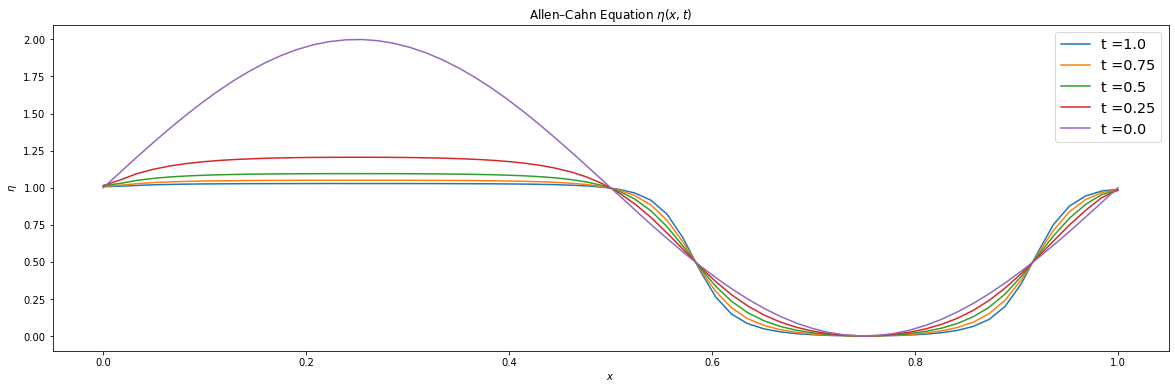

In [149]:
def eta_0(x):
    return sin(2 * pi * x) + 1

figure(figsize = (20, 6));
eta, basis = solve_allen_cahan_forward(eta_0, eps = 0.01, dt = 0.025, ndofs = 64, degree = 1);
plot_solution(eta, basis, s = 10, res = 1025);

## Step 3

<p align = "justify"; style = "font-size:20px;"> Solve the problem for all combinations of

1. <p align = "justify"; style = "font-size:20px;"> eps = [.01, .001], </p>
2. <p align = "justify"; style = "font-size:20px;"> ndofs = [16, 32, 64, 128], </p>
3. <p align = "justify"; style = "font-size:20px;"> degree = [1, 2, 3], </p>
4. <p align = "justify"; style = "font-size:20px;"> dt = [.25, .125, .0625, .03125, 0.15625], </p>

<p align = "justify"; style = "font-size:20px;"> with $\eta_0 = \sin(2 \pi x)+1$. Plot the final solution at $t=1$ in all cases. </p>

In [150]:
eps    = [0.01, 0.001];
ndofs  = [16, 32, 64, 128];
degree = [1, 2, 3];
dt     = [1, 0.25, 0.125, 0.0625, 0.03125, 0.015625];

In [151]:
def plot_combinations(eta_0, eps, ndofs, degree:list, axs, dt, res):
    for j in degree:
        eta, basis = solve_allen_cahan_forward(eta_0,eps = eps, dt = dt, ndofs = ndofs, degree = j)

        x = linspace(0, 1, res); B = zeros((res, len(basis)));
        for i, basis_vector in enumerate(basis):
            B[:, i] = basis_vector(x);

        axs.plot(x, eta[-1].dot(B.T), label = "degree = " + str(j));
        axs.legend(loc = 'lower left');

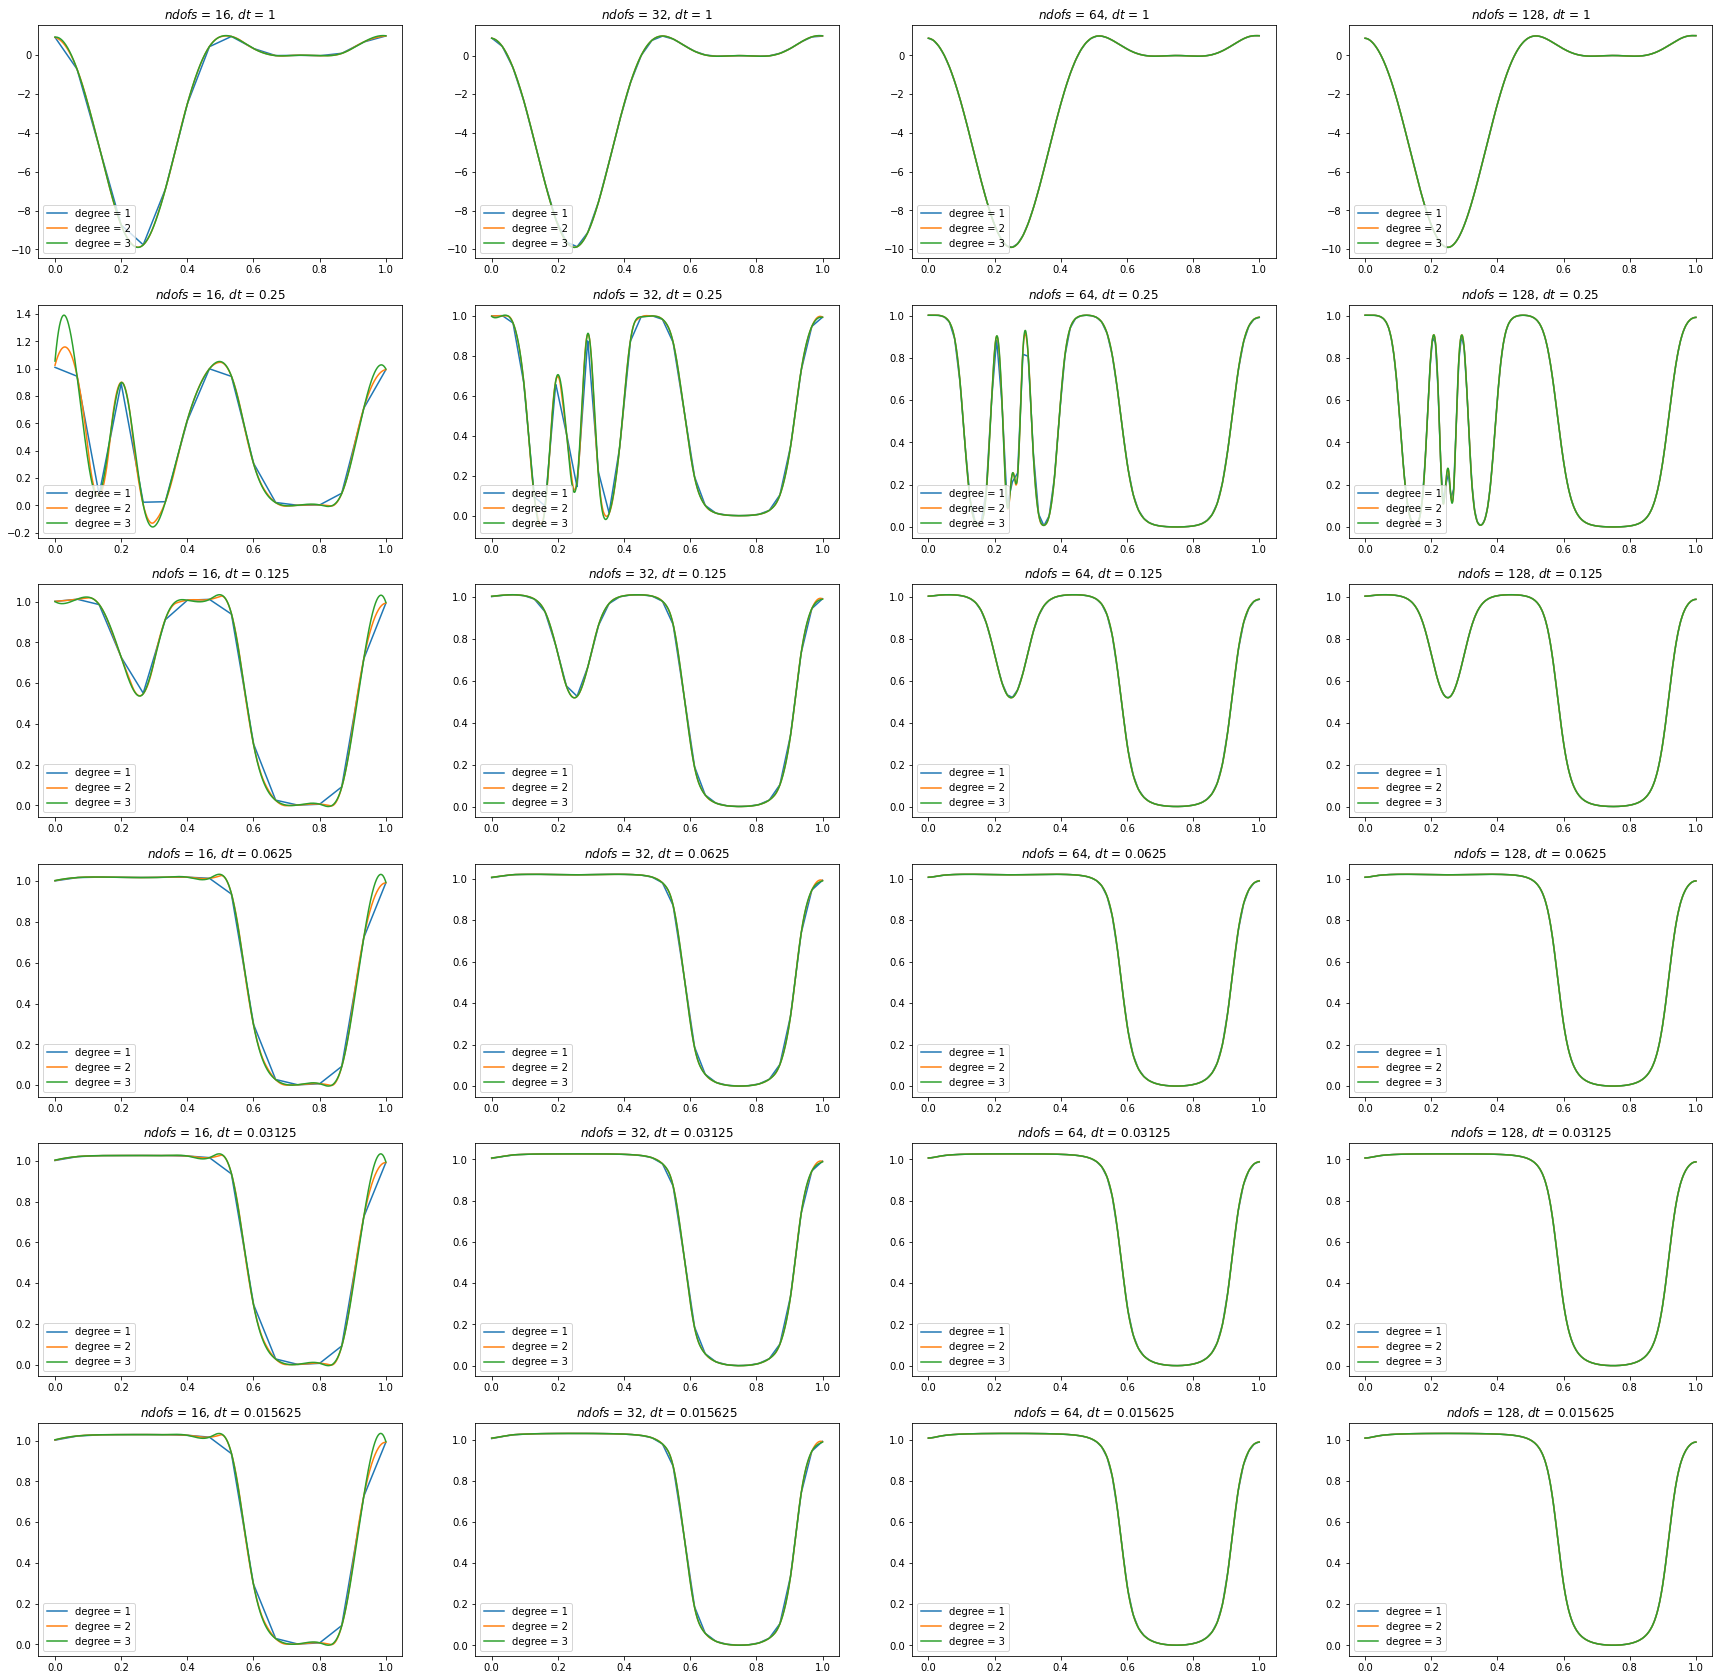

In [152]:
# eps = 0.01;
fig, axs = plt.subplots(nrows = len(dt), ncols = len(ndofs), figsize = (30, 30))
for col, n in enumerate(ndofs):
    for row, d in enumerate(dt):
        axs[row, col].set_title("$ndofs$ = " + str(n) + ", $dt$ = " + str(d))
        plot_combinations(eta_0, eps = eps[0], ndofs = n, degree = degree, dt = d, axs = axs[row, col], res = 1025)

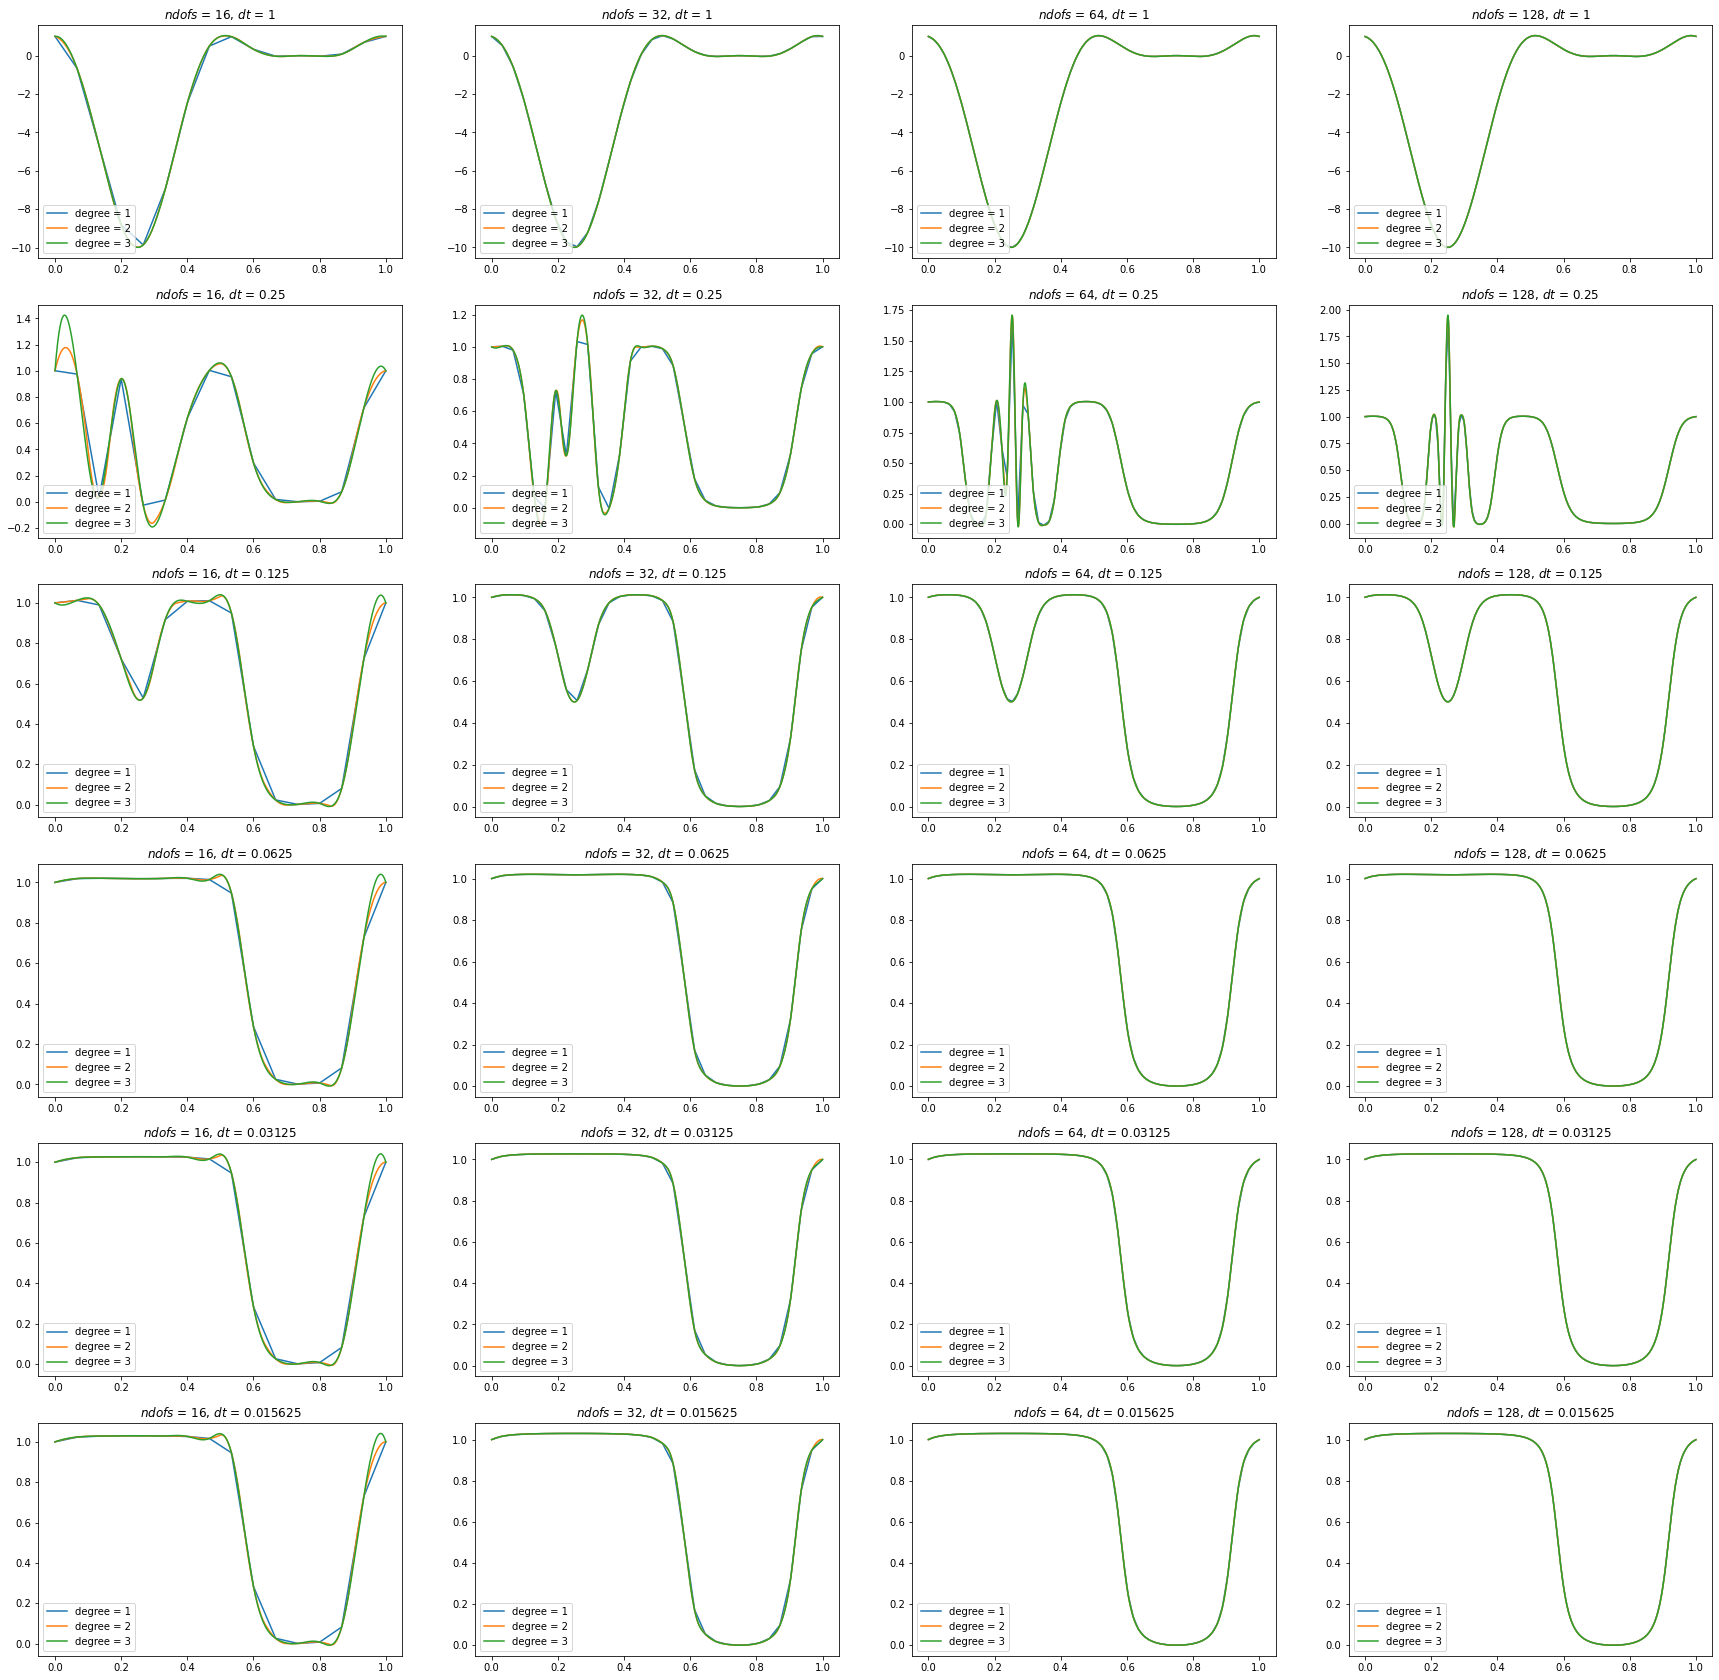

In [153]:
# eps = 0.001;
fig, axs = plt.subplots(nrows = len(dt), ncols = len(ndofs), figsize = (30, 30))
for col, n in enumerate(ndofs):
    for row, d in enumerate(dt):
        axs[row, col].set_title("$ndofs$ = " + str(n) + ", $dt$ = " + str(d))
        plot_combinations(eta_0, eps = eps[1], ndofs = n, degree = degree, dt = d, axs = axs[row, col], res = 1025)

## Step 4

<p align = "justify"; style = "font-size:20px;"> Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a non linear problem at every step. Use scipy and numpy methods to solve the non linear iteration. </p>

In [154]:
def solve_allen_cahan_backward(eta_0_function, eps, dt, ndofs, degree):
    ''' Backward Euler solution. '''

    support_points = linspace(0, 1, ndofs);
    basis, dbasis = compute_basis_functions(support_points, degree);

    Q, W = compute_global_quadrature(basis, degree + 1);
    M, K = compute_system_matrices(basis, dbasis, Q, W);
    A = M + (dt * eps ** 2) * K;

    steps = int(1 / dt); time_interval = [i * dt for i in range(steps + 1)];
    eta = zeros((len(time_interval), ndofs)) # Container for results;
    eta[0,:] = eta_k = eta_0_function(support_points) # Initial values;
    for t in range(1,len(time_interval)):
        eta_k = scipy.optimize.fsolve(lambda x: A.dot(x) - M.dot(eta_k) + dt*M.dot(F(x)), eta_k);
        eta[t,:] = eta_k;

    return eta, basis

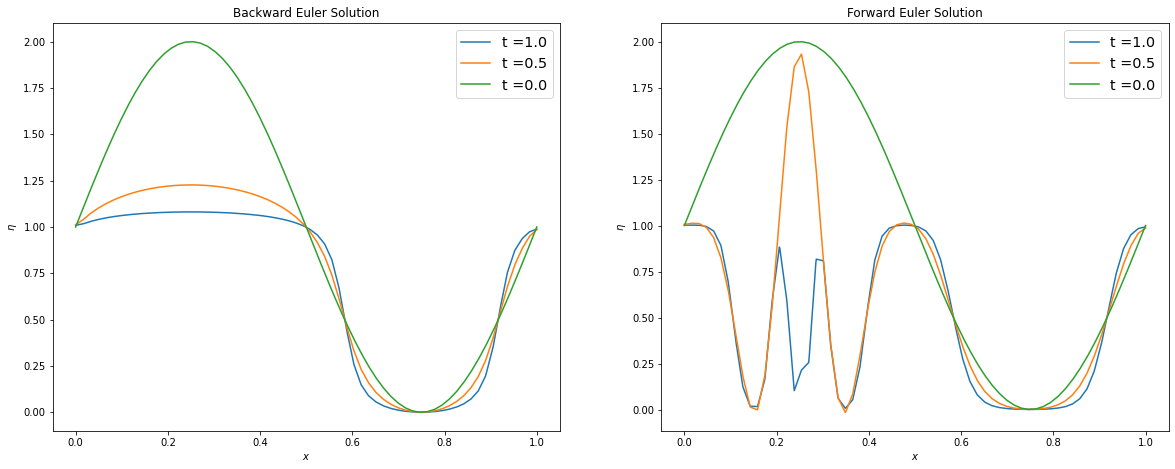

In [155]:
figure(figsize = (20, 7.5));

plt.subplot(1, 2, 1);
eta, basis = solve_allen_cahan_backward(eta_0, eps = 0.01, dt = 0.25, ndofs = 64, degree = 1);
_ = plot_solution(eta, basis, s = 2, res = 1025);
_ = title("Backward Euler Solution");

plt.subplot(1, 2, 2);
eta, basis = solve_allen_cahan_forward(eta_0, eps = 0.01, dt = 0.25, ndofs = 64, degree = 1);
_ = plot_solution(eta, basis, s = 2, res = 1025);
_ = title("Forward Euler Solution");